In [1]:
import re
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Reading the file

In [2]:
filename = 'conversas.txt'

In [3]:
#RETURN TRUE IF THIS IS A DATA LINE
def startsWithDateAndTime(s):
    pattern = '^([0-9]+)\/([0-9]+)\/([0-9]+) ([0-9]+):([0-9]+) ?[AaPp]?[Mm]? -' 
    if re.match(pattern, s):
        return True
    return False

In [4]:
startsWithDateAndTime('7/26/18 22:51 - Bobby: Lorem ipsum dolor sit amet')

True

In [5]:
#RETURN TRUE IF HAS AN AUTHOR ON THE DATA LINE
def hasAuthor(s):
    if(startsWithDateAndTime(s)):
        s=s.split(":")
        if len(s)>2:
            return True
        else:
            return False
    else:
        return False

In [6]:
print(hasAuthor('02/08/2020 16:56 - +55 84 9832-0571: Ofereço: cidade a cidade'))
print(hasAuthor('02/08/2020 17:09 - +55 84 9932-0091: Bom dia!'))
print(hasAuthor('31/03/2018 01:04 - Você foi adicionado(a)'))
print(hasAuthor('fsdfjsf'))

True
True
False
False


In [7]:
#GET INFORMATION FROM THE DATA LINE
def getInformation(s):
    dateMessageSplit = s.split(' - ')
    date,time = dateMessageSplit[0].split(' ')
    message = ' - '.join(dateMessageSplit[1:])
    author = None
    if(hasAuthor(s)):
        author = message.split(':')[0]
        message = ': '.join(message.split(': ')[1:])
    return date,time,author,message

In [8]:
getInformation('02/08/2020 17:09 - +55 84 9932-0091: Bom dia!')
getInformation('02/08/2020 16:56 - +55 84 9832-0571: Ofereço: cidade a cidade')

('02/08/2020', '16:56', '+55 84 9832-0571', 'Ofereço: cidade a cidade')

In [9]:
%%time
messageList=[]
with open(filename,encoding='utf-8') as file:
    file.readline() #Skip first Line
    messageBuffer=[]
    date,time,author,message = None,None,None,None
    while(True):
        line = file.readline()
        if not line: 
            break
        line = line.strip()
        #IF IS A DATA LINE
        if startsWithDateAndTime(line):
            if len(messageBuffer) > 0: 
                messageList.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date,time,author,message = getInformation(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

CPU times: user 19.4 ms, sys: 3.98 ms, total: 23.4 ms
Wall time: 22.5 ms


# Creating the dataframe

In [10]:
df = pd.DataFrame(messageList, columns=['date', 'time', 'author', 'message']) 
df["date"] = pd.to_datetime(df["date"],dayfirst=True)
df.head(10)

,date,time,author,message
0,2019-07-31,08:04,person3,Nam aliquet sapien lectus.
1,2019-12-26,11:52,person6,Interdum et malesuada fames ac ante ipsum prim...
2,2019-06-12,13:43,person1,faucibus. Praesent ac quam at turpis
3,2019-07-24,04:01,person1,facilisis bibendum at a felis. Morbi tincidunt...
4,2019-12-12,20:09,person6,"ullamcorper aliquet. Duis ante justo, facilisi..."
5,2019-04-18,22:38,person2,sagittis🤮
6,2019-04-13,04:06,person3,non nisi. Pellentesque sodales tempus
7,2019-05-19,10:52,person1,"nisi, non consequat magna rutrum vitae. Nam li..."
8,2019-01-29,08:18,person3,"eu malesuada vitae, vulputate vitae tortor. Mo..."
9,2019-05-04,03:12,person0,"libero, commodo sit amet sodales😙"


In [11]:
#CREATE A WORD LIST COLUMN FORM MESSAGE
word_pattern = r"([\w]+)"
digit_pattern = r"([\d]+)"
df['word']=df["message"].str.upper().str.replace(digit_pattern,'').str.findall(word_pattern)

In [12]:
#CREATE EMOJI LIST COLUMN FROM MESSAGE
emoji_pattern = re.compile(
    "(["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "])"
  )
df['emoji'] = df["message"].str.findall(emoji_pattern)

In [13]:
#CREATE URL LIST COLUMN FROM MESSAGE
url_pattern = r"https?://\S+"
df['url'] = df["message"].str.findall(url_pattern)

In [14]:
#CREATE DOMAIN LIST COLUMN FROM URL
domain_pattern = r"https?://([\w.+]+)"
df['domain']=df["message"].str.findall(domain_pattern)

# Cleanning

In [15]:
df = df.dropna(subset=['author'])
df = df.loc[~(df.message.str.contains("<Arquivo de mídia oculto>"))]
df

,date,time,author,message,word,emoji,url,domain
0,2019-07-31,08:04,person3,Nam aliquet sapien lectus.,"[NAM, ALIQUET, SAPIEN, LECTUS]",[],[],[]
1,2019-12-26,11:52,person6,Interdum et malesuada fames ac ante ipsum prim...,"[INTERDUM, ET, MALESUADA, FAMES, AC, ANTE, IPS...",[],[],[]
2,2019-06-12,13:43,person1,faucibus. Praesent ac quam at turpis,"[FAUCIBUS, PRAESENT, AC, QUAM, AT, TURPIS]",[],[],[]
3,2019-07-24,04:01,person1,facilisis bibendum at a felis. Morbi tincidunt...,"[FACILISIS, BIBENDUM, AT, A, FELIS, MORBI, TIN...",[],[],[]
4,2019-12-12,20:09,person6,"ullamcorper aliquet. Duis ante justo, facilisi...","[ULLAMCORPER, ALIQUET, DUIS, ANTE, JUSTO, FACI...",[],[],[]
...,...,...,...,...,...,...,...,...
2412,2019-10-26,23:28,person1,condimentum🤑,[CONDIMENTUM],[🤑],[],[]
2413,2019-08-29,16:25,person5,velit blandit dictum.,"[VELIT, BLANDIT, DICTUM]",[],[],[]
2414,2018-01-27,02:43,person0,Fusce mollis non,"[FUSCE, MOLLIS, NON]",[],[],[]
2415,2019-07-24,15:33,person6,neque id,"[NEQUE, ID]",[],[],[]


# Showing information

In [16]:
#RETURN A PANADAS DATAFRAME WITH THE LIST OF ALL ITEMS FROM A COLUMN WITH LISTS INT THE DATAFRAME
def toUniqueList(serie):
    uniqueList=[]
    for row in serie:
        uniqueList+=row
    return pd.DataFrame(uniqueList)
#CREATE A DATAFRAME WITH THE COUNT OF A LIST OF ITEMS FROM A LIST-COLUMN
def countDataframe(serie):
    return pd.DataFrame(toUniqueList(serie).value_counts(),columns=["count"]).reset_index().rename(columns={0:"item"})

In [23]:
#EMOTICONS
if len(toUniqueList(df.emoji))!=0:
    fig = px.pie(countDataframe(df.emoji).head(10),values='count',names='item')
    fig.update_traces(textposition='inside', textinfo='percent+label',
                      title="Top 10 emoticons mais usados")
    fig.show()

In [18]:
#PALAVRAS
fig = px.pie(countDataframe(df.word).head(20),values='count',names='item')
fig.update_traces(textposition='inside', textinfo='percent+label',
                  title="Top 20 palavras mais utilizadas")
fig.show()

In [19]:
#SITES
if len(toUniqueList(df.domain))!=0:
    fig = px.bar(toUniqueList(df.domain),title="Dominios de sites mais comentados do grupo")
    fig.show()

In [20]:
#PESSOAS
fig = px.bar(df.author.value_counts().head(20),title="Top 20 pessoas que mais falam")
fig.show()

In [21]:
#MENSAGENS PELO TEMPO
fig = px.bar(df.date.value_counts().sort_index(),title="Mensagens por dia")
fig.show()

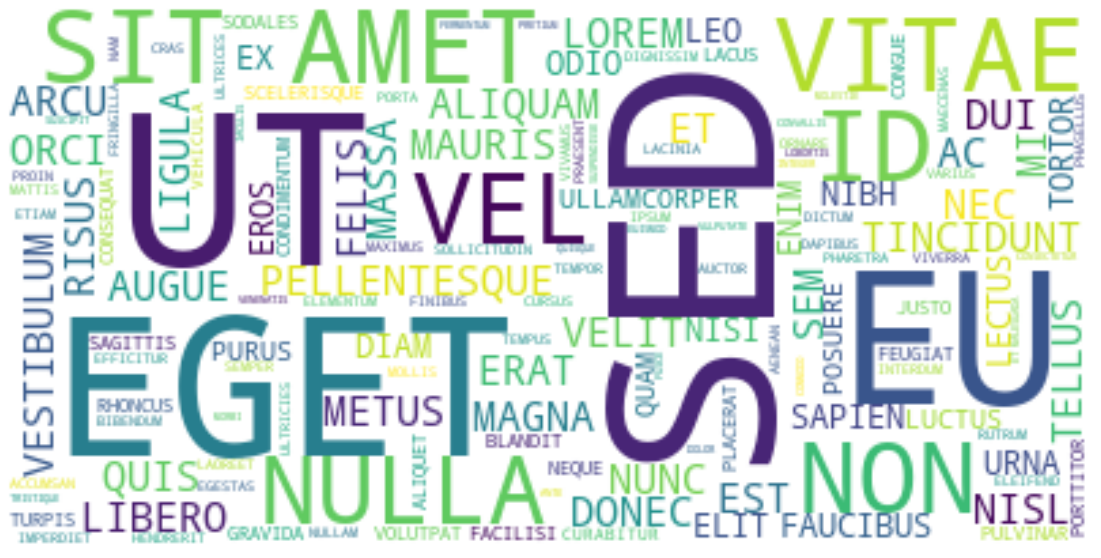

In [22]:
complete_text = ' '.join(toUniqueList(df.word)[0])
wordcloud = WordCloud(max_words=200, background_color="white").generate(complete_text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()